In [55]:
import pygmt
import pandas as pd
region = [-10.5, -5, 51.5, 55.5]

**Function to prepare and select the blast catalogue data per quarry**

In [75]:
#Function to select the events within a radius of a quarry
def quarry_select(quarry_locations_df, blast_catalogue_df, radius):
    #relocate blasts using gmt select

    relocated_blasts = pd.DataFrame()
    result = pd.DataFrame()
    
    #convert to lon, lat (ASCII) to load into gmt select
    blast_catalogue_df.to_csv('Eire_blasts.gmt', 
            columns=['LON(deg)','LAT(deg)','EVENT-ID'], 
            sep="\t", 
            header=False, 
            index=False)

    for index,row in quarry_locations_df.iterrows():
        quarry_lat = quarry_locations_df.loc[index,"lat"]
        quarry_lon = quarry_locations_df.loc[index,"lon"]
        #quarry_name = quarries.loc[index,"name"]
        quarry_loc = str(quarry_lon)+"/"+str(quarry_lat)
        
        result = pygmt.select(data='Eire_blasts.gmt',
                            output_type="pandas",
                            dist2pt=quarry_loc+'+d'+radius,
                            region=region)
        
        if not result.empty:
            result['new-lon'] = quarry_lon
            result['new-lat'] = quarry_lat
            relocated_blasts = pd.concat([relocated_blasts, result], ignore_index=True)

    if not relocated_blasts.empty:
        relocated_blasts.columns = ["lon_ev", "lat_ev", "id-ev", "lon-quarry", "lat-quarry"] #, "name-quary"
    
    # Filter values that appear more than once
    value_counts = relocated_blasts['id-ev'].value_counts()
    repeated_values = value_counts[value_counts > 1]
    if not repeated_values.any():
         print('    ~~~the selection radius '+str(radius)+' found ' +str(relocated_blasts.shape[0])+' matches and no double assigments.')
    else: 
        print('    ~~~the selection radius '+str(radius)+' found ' +str(relocated_blasts.shape[0])+' matches and '+str(repeated_values.iloc[0].max())+' non-unique assigments.')
    
    #build new event list with the remaining blasts
    remain_blasts = blast_catalogue_df[~blast_catalogue_df['EVENT-ID'].isin(relocated_blasts["id-ev"])]
    print("    ~~~out of "+str(blast_catalogue_df.shape[0])+" initial events, "+str(remain_blasts.shape[0])+" quarry blast events remain")
    return relocated_blasts,remain_blasts

**Load station,  quarry and blast data**

In [57]:
# Load station data to lon lat file and dataframe
stations_head = ['sta', 'name','lat', 'lon', 'elevation', 'net', 'end']
stations = pd.read_csv(
    "/mnt/store/senad/repos/for_bruna/QUARRY_BLASTS/ADMIN/Ireland_Britain_Stations", 
    delimiter=' ',
    names=stations_head)

In [58]:
quarries = pd.read_csv(
    '/home/bmelo/bin/Quarry/quarry_new_update1.gmt',
    header=0, 
    sep=r'\s+',
    names=['lon','lat'])
quarries['z']=1


In [ ]:
blasts = pd.read_csv(r'/mnt/REPO/QUARRY-BLASTS/CATALOGS/quarry-blast-catalog-2013-2014.csv', 
                     sep=r'\s+')

,EVENT-ID,DATE,TIME,LAT(deg),LAT-ERR(km),LON(deg),LON-ERR(km),DEPTH(km),RMS(s),AZ-GAP(deg),N_PHASES,MAG(ML)
0,dias2013kwhe,2013-06-04,11:58:42.744,54.38776,0.758,-7.38951,1.278,0.0,0.408,105.6,50,1.29
1,dias2013kwks,2013-06-04,13:45:39.377,52.90088,0.933,-9.05663,1.010,0.0,0.308,68.8,44,1.56
2,dias2013kwle,2013-06-04,14:00:17.523,53.44080,0.973,-7.16199,0.966,0.0,0.412,87.2,46,1.18
3,dias2013kwlj,2013-06-04,14:05:07.330,52.59792,1.510,-7.19376,1.283,0.0,0.360,88.0,24,1.16
4,dias2013kwls,2013-06-04,14:16:21.183,53.32669,0.858,-9.01190,0.911,0.0,0.488,69.5,55,1.71
...,...,...,...,...,...,...,...,...,...,...,...,...
1406,dias2014yseq,2014-12-18,11:39:07.112,54.63316,1.670,-6.76778,1.267,0.0,0.318,83.8,19,1.15
1407,dias2014ysgw,2014-12-18,12:46:48.262,53.26357,1.970,-6.48678,1.498,0.0,0.540,116.4,17,0.76
1408,dias2014yshe,2014-12-18,12:55:53.479,54.25886,1.232,-6.57365,1.464,0.0,0.246,88.8,24,0.99
1409,dias2014yucm,2014-12-19,12:50:04.704,54.53238,1.589,-8.05661,1.761,0.0,0.350,107.3,18,1.09


In [98]:
radius = [0.005, 0.0055, 0.007, 0.009, 0.0095, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# Initialize relocated_blasts_all
relocated_blasts_all = pd.DataFrame()
blasts_catalogue = pd.read_csv(r'/mnt/REPO/QUARRY-BLASTS/CATALOGS/quarry-blast-catalog-2013-2014.csv', 
                     sep=r'\s+')

remain_blasts_catalogue = blasts_catalogue
for r in radius:
    print("~~~processing radius "+str(r))
    quarry_blasts, remain_blasts_catalogue = quarry_select(quarries, remain_blasts_catalogue, str(r))
    relocated_blasts_all = pd.concat([relocated_blasts_all, quarry_blasts], ignore_index=True)


~~~processing radius 0.005


    ~~~the selection radius 0.005 found 93 matches and no double assigments.
    ~~~out of 1411 initial events, 1318 quarry blast events remain
~~~processing radius 0.0055
    ~~~the selection radius 0.0055 found 22 matches and no double assigments.
    ~~~out of 1318 initial events, 1296 quarry blast events remain
~~~processing radius 0.007
    ~~~the selection radius 0.007 found 54 matches and no double assigments.
    ~~~out of 1296 initial events, 1242 quarry blast events remain
~~~processing radius 0.009
    ~~~the selection radius 0.009 found 96 matches and no double assigments.
    ~~~out of 1242 initial events, 1146 quarry blast events remain
~~~processing radius 0.0095
    ~~~the selection radius 0.0095 found 20 matches and no double assigments.
    ~~~out of 1146 initial events, 1126 quarry blast events remain
~~~processing radius 0.02
    ~~~the selection radius 0.02 found 571 matches and 2 non-unique assigments.
    ~~~out of 1126 initial events, 584 quarry blast events rem

(1478, 5)

In [96]:
relocated_blasts1,remain_blasts1 = quarry_select(quarries,remain_blasts_catalogue,"0.06")
#quarries


    ~~~the selection radius 0.06 found 15 matches and 3 non-unique assigments.
    ~~~out of 29 initial events, 18 quarry blast events remain


**Plot results with PyGMT**

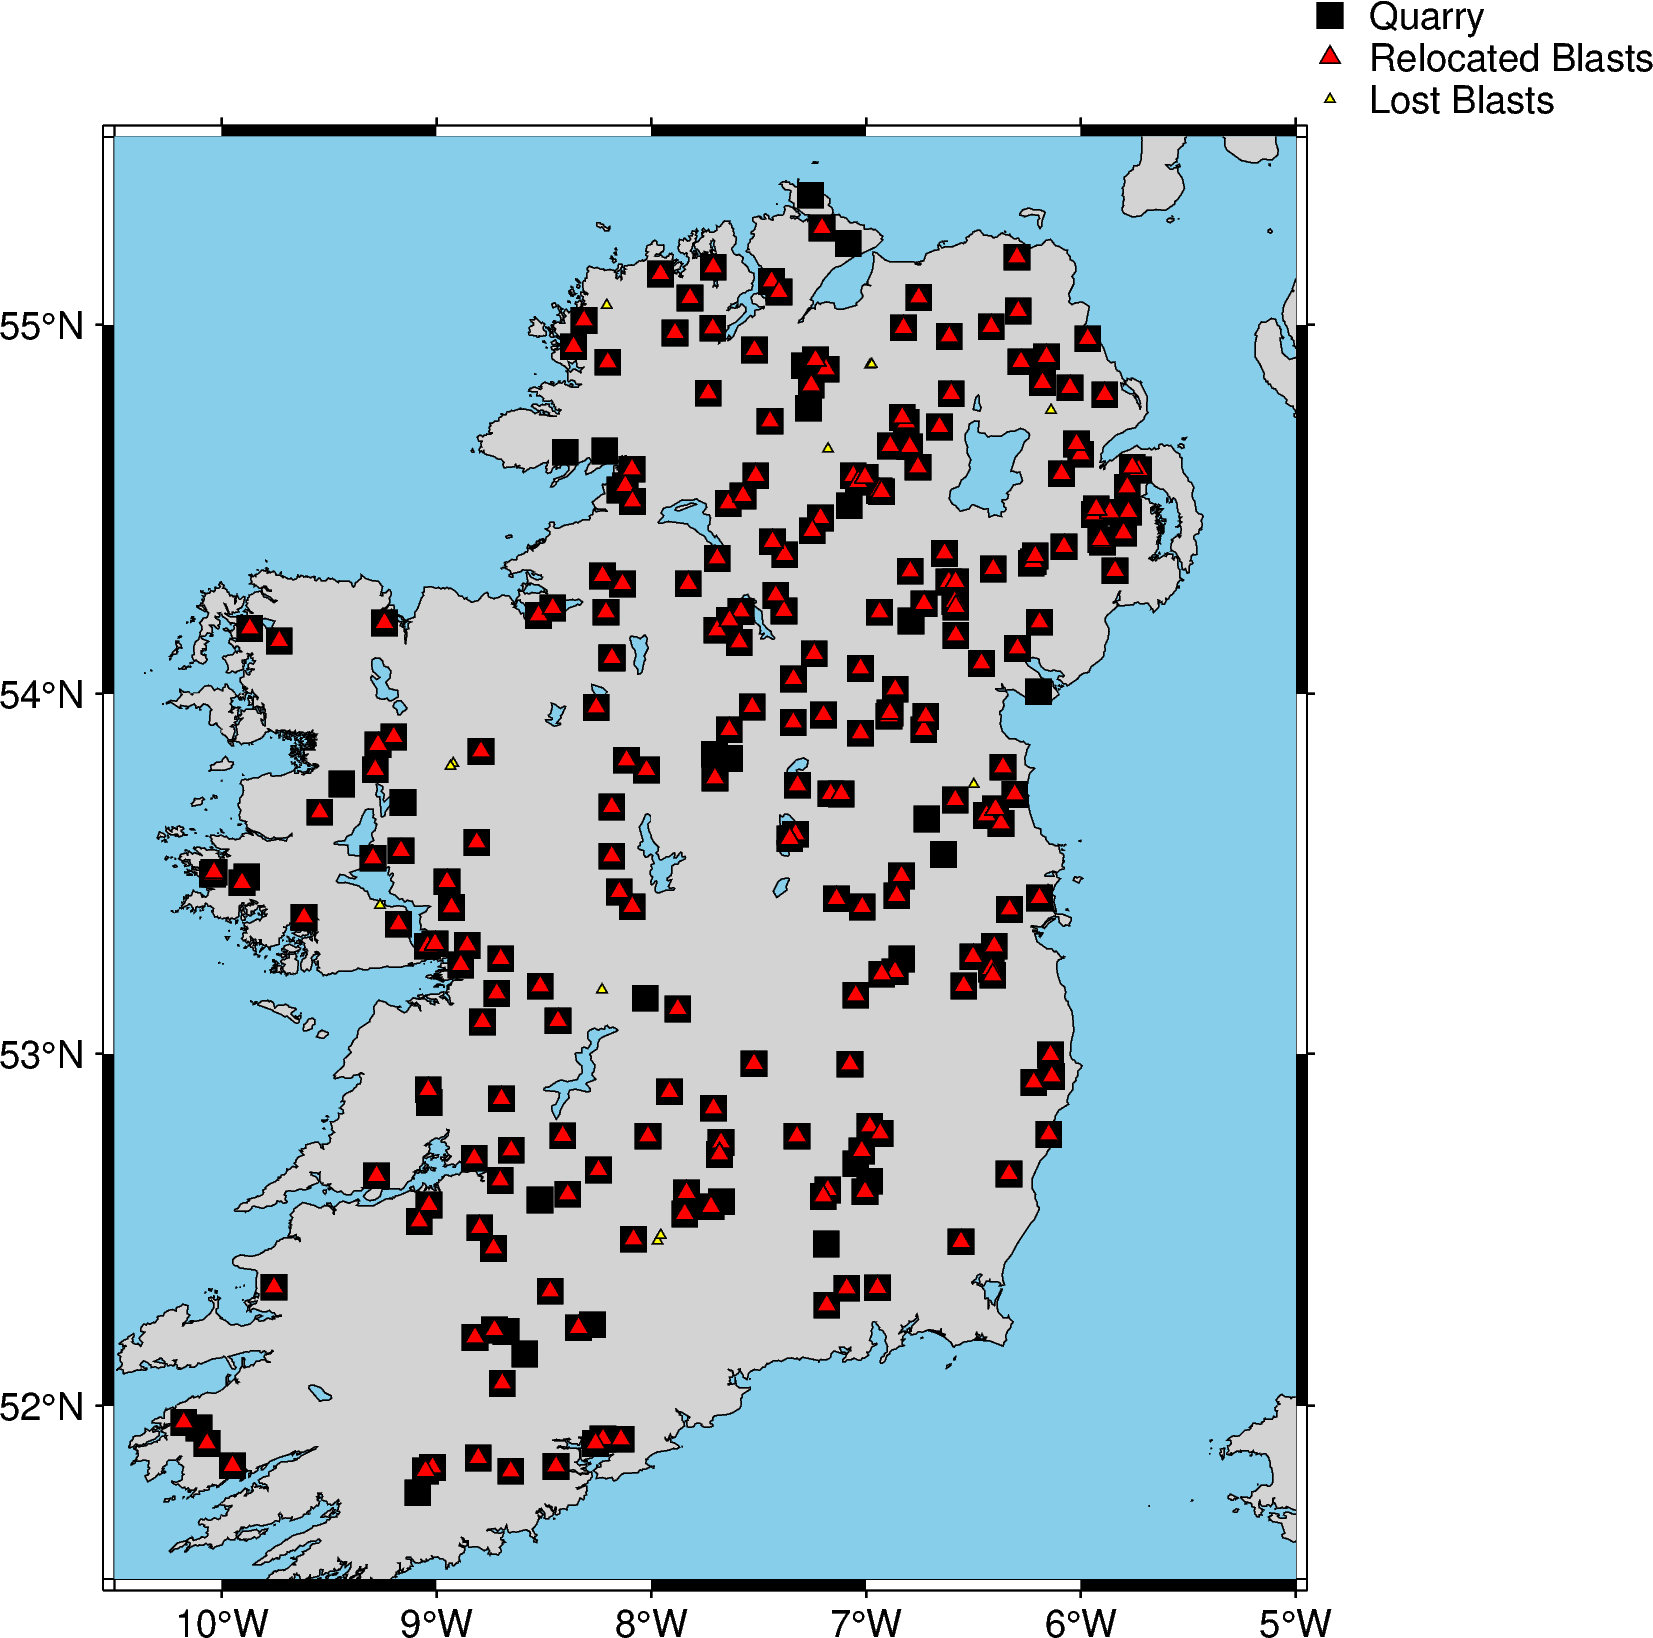

In [ ]:
fig = pygmt.Figure()
fig.basemap(region=region, projection="M10c", frame="a1")
fig.coast(shorelines=True, water="skyblue", land="lightgray")
#Plot quarry mine locations as black circles
fig.plot(
    x=quarries["lon"],
    y=quarries["lat"],
    style="s0.3c",
    fill="black",
    pen="black",
    label="Quarry"
)
#Plot relocated blasts as red circles
fig.plot(x=relocated_blasts_all["lon-quarry"],
         y=relocated_blasts_all["lat-quarry"],
         style="t0.2c",
         fill="red",
         pen="black",
         label="Relocated Blasts")
#Plot remaining blasts as yellow circles
fig.plot(
    x=remain_blasts_catalogue['LON(deg)'],
    y=remain_blasts_catalogue['LAT(deg)'],
    style="t0.1c",
    fill="yellow",
    pen="black",
    label="Lost Blasts"
)
fig.legend(position="JTR")
fig.show()

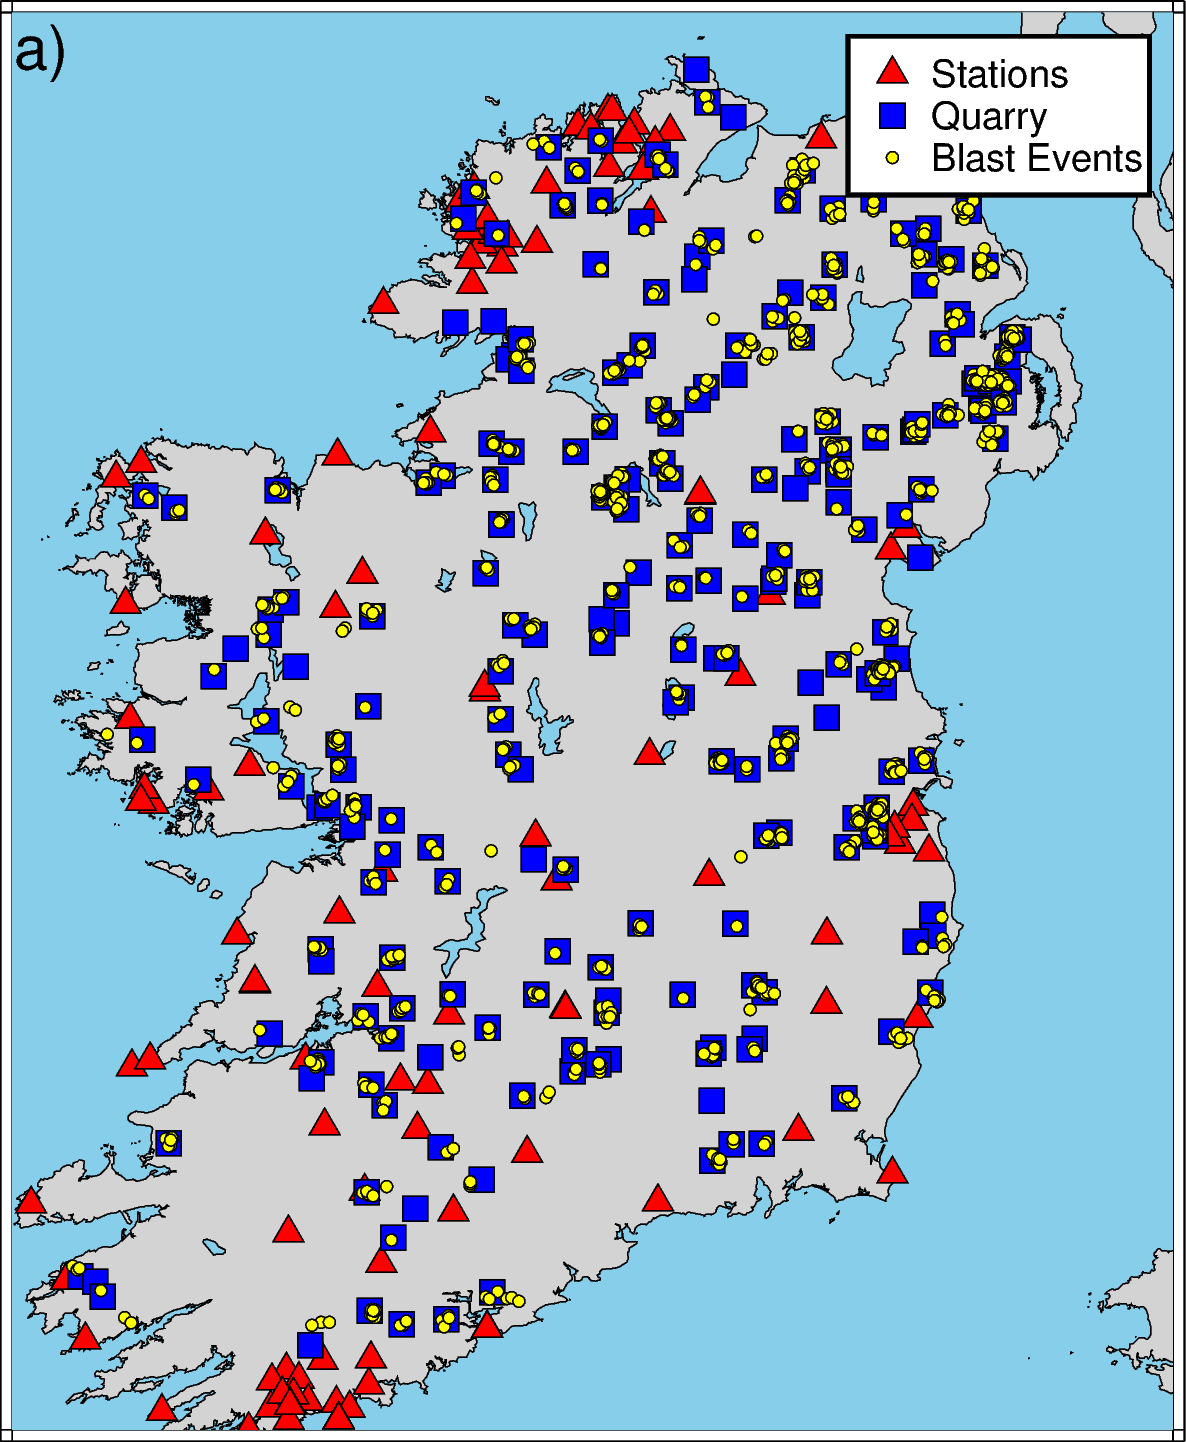

In [ ]:
# fig = pygmt.Figure()
# with fig.subplot(nrows=1, ncols=1, figsize=("10c","12c"), autolabel=True, sharex="b", sharey="l", frame=["WSen","f50"]):
# # Subplot with original blast locations
#     fig.basemap(region=region, projection="M?", panel=True)
#     fig.coast(shorelines=True, water="skyblue", land="lightgray")
#     # Plot the station locations
#     fig.plot(
#         x=stations['lon'],
#         y=stations['lat'],
#         style="t0.3c",  # Circle with 0.3 cm size
#         fill="red",
#         pen="black",
#         label="Stations"
#     )
#     quarry='/home/bmelo/bin/Quarry/IRELAND.quarry.coords_newBM.txt'
#     fig.plot(
#         quarry,
#         #x=quarry['LON(deg)'],
#         #y=quarry['LAT(deg)'],
#         style="s0.3c",  # Circle with 0.3 cm size
#         fill="blue",
#         pen="black",
#         label="Quarry"
#     )

#     fig.plot(
#         x=blasts['LON(deg)'],
#         y=blasts['LAT(deg)'],
#         style="c0.1c",  # Circle with 0.3 cm size
#         fill="yellow",
#         pen="black",
#         label="Blast Events"
#     )
#     # # Add a legend
#     # fig.legend(position="JTC")
    
# # Show the figure
# fig.show()
# fig.savefig("quarry_ireland.png")
